In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# build dataset

def build_dataset(words):
    block_size = 3 # how many characters do we take to predict next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(52)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
g = torch.Generator().manual_seed(434321)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [6]:
for p in parameters:
    p.requires_grad = True

In [7]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [8]:
lri = []
lossi = []
stepi = []

In [9]:

for i in range(30000):
    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6)@W1 + b1)
    logits = h @ W2 + b2
    #counts = logits.exp()
    #probs = counts / counts.sum(1, keepdims=True)
    #loss = -probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    break
print(loss.item())

19.172632217407227


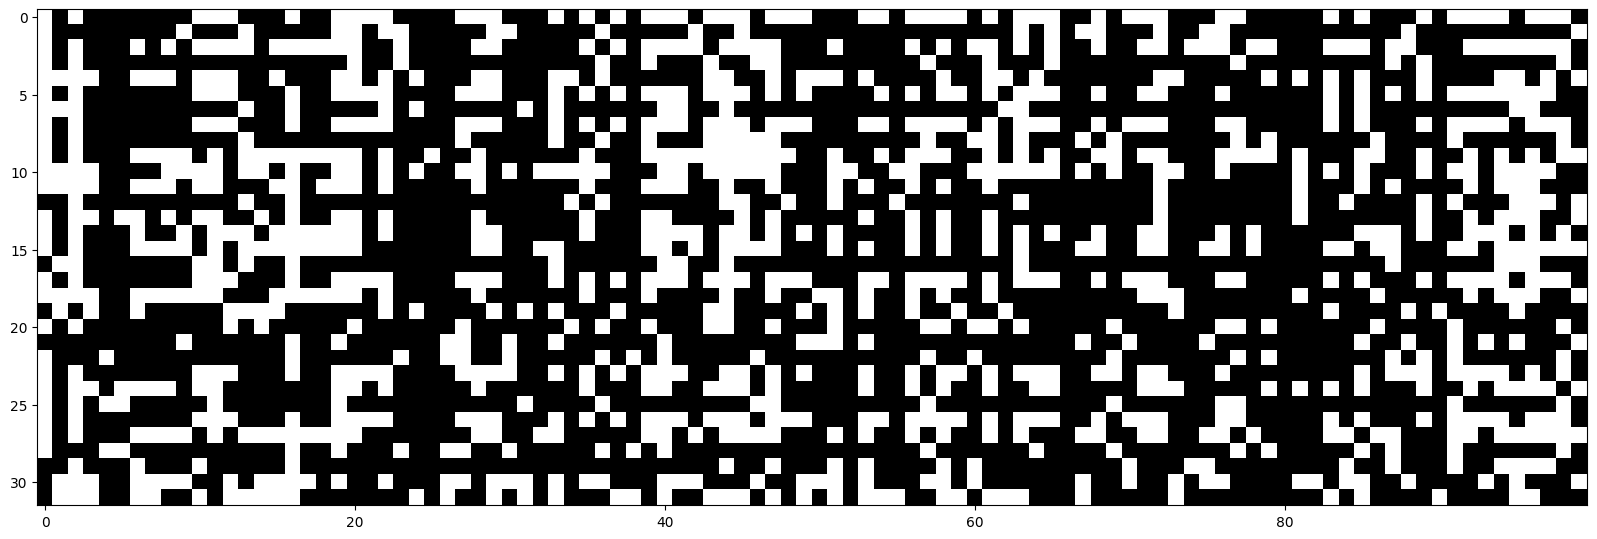

In [22]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([763., 118.,  73.,  68.,  66.,  47.,  36.,  44.,  33.,  28.,  26.,
         29.,  20.,  25.,  18.,  29.,  20.,  18.,  15.,  16.,  18.,  17.,
         15.,  21.,  17.,  16.,  19.,  19.,  25.,  23.,  29.,  15.,  20.,
         15.,  21.,  13.,  25.,  36.,  27.,  28.,  35.,  20.,  32.,  39.,
         48.,  42.,  53.,  92., 118., 810.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

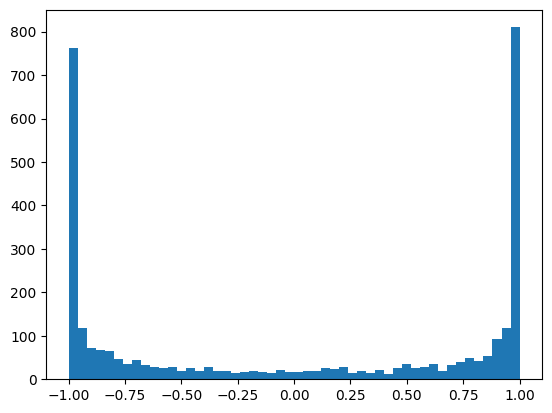

In [18]:
plt.hist(h.view(-1).tolist(), 50)

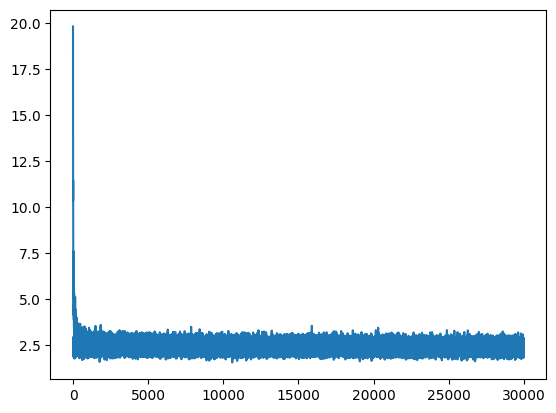

In [95]:
plt.plot(stepi, lossi)

In [96]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3378, grad_fn=<NllLossBackward0>)

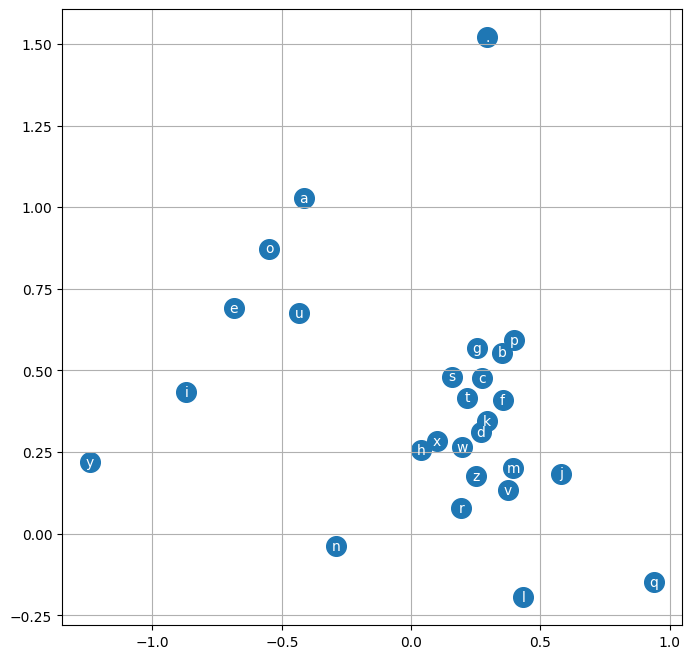

In [102]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

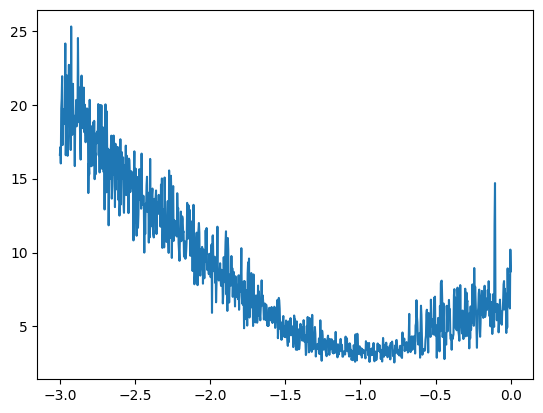

In [43]:
plt.plot(lri, lossi)